In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env ANTHROPIC_API_KEY=your_anthropic_api_key_here


env: ANTHROPIC_API_KEY=your_anthropic_api_key_here


In [70]:
# Fix the import path issue by adding the project root to Python path
import sys
import os

# Add the project root directory to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Added {project_root} to Python path")


Added /Users/sinanozdemir/Teaching/Pearson/applied-ai-book to Python path


# Computer Use vs Reasoning

In [71]:
from huggingface_hub import snapshot_download

# Download the UiPad dataset repository locally
local_dir = snapshot_download(
    repo_id="MacPaw/UiPad",   # dataset repo on HF Hub
    repo_type="dataset",      # tell the hub this is a dataset, not a model
    local_dir="uipad_dataset" # folder the repo will be cloned into
)

print(f"Repo downloaded to → {local_dir}")

# Now you can work with the images in their folder structure
import glob
from PIL import Image

# Find all image files
all_images = glob.glob(f"{local_dir}/**/*.png", recursive=True) + \
             glob.glob(f"{local_dir}/**/*.jpg", recursive=True) + \
             glob.glob(f"{local_dir}/**/*.jpeg", recursive=True)

print(f"Found {len(all_images)} images")

# Load the dataset with the original datasets library too
from datasets import load_dataset
dataset = load_dataset("MacPaw/UiPad")


Fetching 595 files:   0%|          | 0/595 [00:00<?, ?it/s]

Repo downloaded to → /Users/sinanozdemir/Teaching/Pearson/applied-ai-book/reasoning_llms/computer_use/uipad_dataset
Found 352 images


In [72]:
def find_image_path(screen_id, all_images):
    for img_path in all_images:
        if '/' + str(screen_id) + '/' in img_path:
            return img_path
    return None

find_image_path(dataset['test'][0]['Screen id'], all_images)

'/Users/sinanozdemir/Teaching/Pearson/applied-ai-book/reasoning_llms/computer_use/uipad_dataset/app_data/Almighty/1707228310/Almighty-1707228311.45.png'

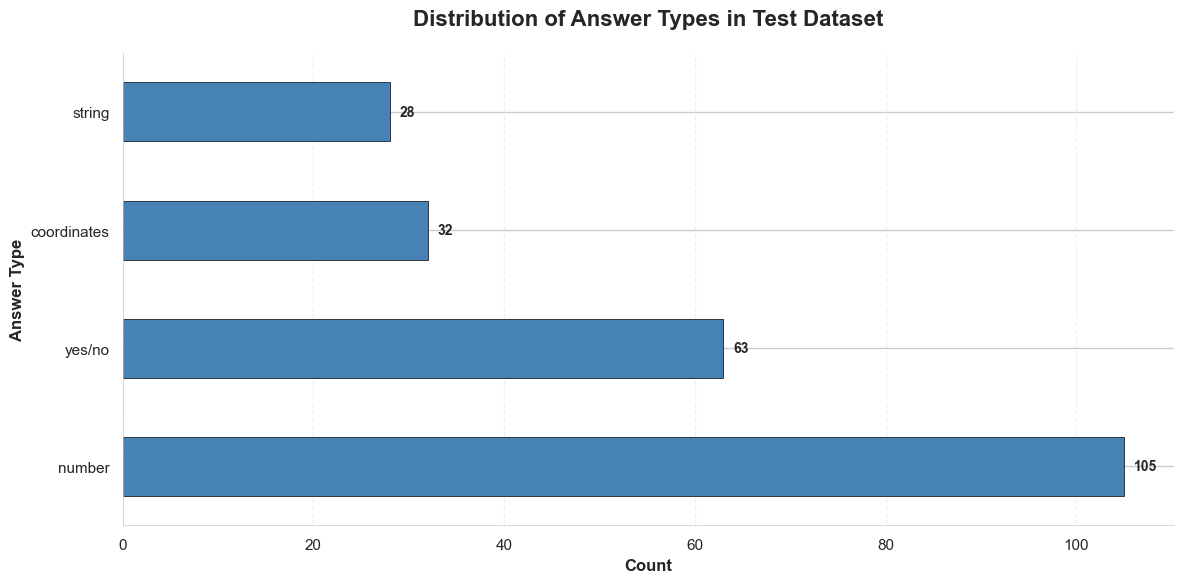

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a horizontal bar chart of answer types
answer_type_counts = pd.Series(dataset['test']['Answer Type']).value_counts()

plt.figure(figsize=(12, 6))
bars = answer_type_counts.plot(kind='barh', color='steelblue', edgecolor='black', linewidth=0.5)

plt.title('Distribution of Answer Types in Test Dataset', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Count', fontsize=12, fontweight='bold')
plt.ylabel('Answer Type', fontsize=12, fontweight='bold')

# Add value labels on the bars
for i, (index, value) in enumerate(answer_type_counts.items()):
    plt.text(value + max(answer_type_counts) * 0.01, i, str(value), 
             va='center', ha='left', fontsize=10, fontweight='bold')

# Improve styling
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)

plt.tight_layout()
plt.show()

{'Answer': '0',
 'Answer Type': 'number',
 'App bundle': 'com.onmyway133.Almighty-setapp',
 'App name': 'Almighty',
 'Question': 'How many toggle buttons are turned on?',
 'Screen id': 1707228237}
1707228237


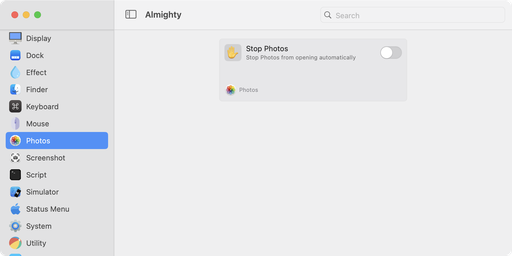

In [17]:
# Find the image corresponding to the first test example
first_example = dataset['test'][2]
from pprint import pprint
pprint(first_example)
screen_id = first_example['Screen id']
print(screen_id)
# Search for the image file with the matching screen id in its filename
import os

matching_image = find_image_path(screen_id, all_images)

# Optionally, display the image if found (display in medium size, do not open in external viewer)
if matching_image:
    from IPython.display import display
    img = Image.open(matching_image)
    # Resize to medium size (e.g., width=512, maintain aspect ratio)
    max_width = 512
    if img.width > max_width:
        ratio = max_width / img.width
        new_size = (max_width, int(img.height * ratio))
        img = img.resize(new_size, Image.LANCZOS)
    display(img)

In [18]:
from langchain_anthropic import ChatAnthropic
llms = {
            
            'reasoning anthropic claude sonnet 4': ChatAnthropic(
                model="claude-sonnet-4-0",
                max_tokens=5000,
                model_kwargs={"thinking": {"type": "enabled", "budget_tokens": 4000}},
            ),

            'no reasoning anthropic claude sonnet 4': ChatAnthropic(
                model="claude-sonnet-4-0",
                max_tokens=5000,
                model_kwargs={"thinking": {"type": "disabled"}},
            ),
            'reasoning anthropic claude opus 4.1': ChatAnthropic(
                model="claude-opus-4-1-20250805",
                max_tokens=5000,
                model_kwargs={"thinking": {"type": "enabled", "budget_tokens": 4000}},
            ),

            'no reasoning anthropic claude opus 4.1': ChatAnthropic(
                model="claude-opus-4-1-20250805",
                max_tokens=5000,
                model_kwargs={"thinking": {"type": "disabled"}},
            ),

        }

In [19]:
from langchain_core.prompts import ChatPromptTemplate
import base64
from io import BytesIO
from textwrap import dedent
from PIL import Image

def image_to_base64(image_path):
    """
    Loads an image from the given path and returns the PIL Image object and its base64-encoded JPEG string.
    """
    img = Image.open(image_path)
    buffered = BytesIO()
    # Convert RGBA images to RGB before saving as JPEG
    if img.mode == "RGBA":
        img_rgb = img.convert("RGB")
    else:
        img_rgb = img
    img_rgb.save(buffered, format="JPEG")
    image_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img, image_base64

# Create a reusable prompt template using ChatPromptTemplate
prompt_template = ChatPromptTemplate.from_messages([
    ("system", dedent("""
        You are a web-based assistant that will help the user with their questions.
        You will be given a question and an image of a web-based interface.
        You will need to answer the question based on the image.

        If you need to tell the user where to click, or hover the mouse, please give \
        bounding box coordinates in the form of [(x1, y1), (x2, y2)] where x1 and y1 are the \
        pixel coordinates of the upper left corner of the bounding box and x2 and y2 are the \
        coordinates of the lower right corner of the bounding box.

        The screen dimensions are Width={screen_width}px by Height={screen_height}px.

        Otherwise, just answer the question whether it's asking for a number, a text, or a button.
    """)),
    (
        "human",
        [
            {"type": "text", "text": "{question}"},
            {
                "type": "image_url",
                "image_url": {"url": "{image_base64}"},
            },
        ],
    ),
])

img, image_base64 = image_to_base64(find_image_path(first_example['Screen id'], all_images))

# Format the prompt with variables
messages = prompt_template.format_messages(
    screen_width=img.width,
    screen_height=img.height,
    question=first_example['Question'],
    image_base64=f"data:image/jpeg;base64,{image_base64}"
)

llm = llms['reasoning anthropic claude opus 4.1']
response = llm.invoke(messages)
print(response)

content=[{'signature': 'Ep8GCkYIBhgCKkBoI9ekGgMEsrn6GAB5uI+n7Ltn3jo9f/DBFxxVas8rWnh9giCx4D4jTK9ukR9oO16ArDEivryDJJeCycBaUv+QEgxcqsoRXRpOD1zdL5QaDIDN/YvutbEen2WXJyIwpnx990XM16hM6mbz303A4zHe1kG4kqGazJKhw4143hIEveCx9QfuXpGJa/cV7RjzKoYF1zKgpguKzeMAGiUnUZ+/HonlZ7BDPEolOYeCxB4phmWxW/EPqZLFdwDbae/6oSmAaTGG4ASrD9jWdy8azLpjlCiqpIxX1iQJuszNVDB4tYXTPXgkZUWXG5kQjgA3BF7QgeJGBdpKascuaZ/PrYhYPhR45nDIGTHOwtoQTU8zLoFQwpjE/yh/a6pnLhC8eE3QX/4siOFtYhkv7/KJmrHR0a7b9kSbhvmkECc8eSz1YKSJZjGCg0i1HAIqEmXkE+MFApsxiLWIVEe8pqCCqvrvoUKIL2MZ0/SMl5NIHKXfok2CH3DOSirZUv+JG57Qj18VXZiipd4jSH+WqkY9P+/HoacAnedZfMhbxbza4mWz5yzScFgsm4LxC6P0uuGEdaZIoM3OpMAPJ5sAv01YgksVdufrx90uM8XzqAahC1w9TQvbE1Ij5yyRVNoiGuA9dEwVcTyx8vJweM9UBvi9Py4cWFj55P6evkrlD3ohefb9Ep27sCL7qfC42MfWeWppuMVDtO/R2x1jx6pImtCKUPWcpBIAuqcQYZGH6m05G6Gzkp8Xbgl2S+B2gTnd8YePejq7s0gPP80rggYMg7KeExPwNAczLSyJizdjKXvMuwawBGqO4IDLQlv6NOUM1qHXBlX1MwMxKbNed1Nb3J7I3RAW5EUGSt2axoUABFy4Bp2E5sIO0Iwkt/FwJbWvJIuhFwpuq53jOVhlPVPuq2UI2Q8y8sO+RoYVU5Lt/TIyD164hwP0SEEWuO4QzUjALKEGcktP

In [20]:
response.content[-1]['text']

'Looking at the image, I can see one toggle button for "Stop Photos" which appears to be turned **off** (the toggle switch is positioned to the left and appears gray/white).\n\nTherefore, there are **0** toggle buttons turned on.'

In [21]:
from policy_bot.ai.rubric import get_structured_scorer

score_ai_response = get_structured_scorer(model_name="meta-llama/llama-4-maverick")

rubric_result = score_ai_response(
    question=first_example['Question'],
    ai_response=response.content[-1]['text'],
    ground_truth=first_example['Answer']
)

rubric_result

ScoreResponse(reasoning="The AI response correctly identifies that there are 0 toggle buttons turned on, matching the ground truth. The AI provides a detailed explanation by mentioning a specific toggle button ('Stop Photos') and its state (turned off), supporting the conclusion that there are 0 toggle buttons turned on. The response is accurate and complete.", score=3)

In [28]:
for answer_type in pd.Series(dataset['test']['Answer Type']).unique():
    print(answer_type)
    # Get the indices where the answer type matches
    matching_indices = [i for i, at in enumerate(dataset['test']['Answer Type']) if at == answer_type]
    if matching_indices:
        # Randomly select one index
        import random
        random_index = random.choice(matching_indices)
        random_example = dataset['test'][random_index]
        print(random_example['Question'])
        print(random_example['Answer'])
    else:
        print("No examples found for this answer type.")
    print('-'*100)

number
How many buttons are there on the screen?
2
----------------------------------------------------------------------------------------------------
yes/no
Is there a search bar on the screen?
No
----------------------------------------------------------------------------------------------------
string
What is the name of the displayed app?
Diarly
----------------------------------------------------------------------------------------------------
coordinates
Where to click to return to the previous screen?
[(26, 1242), (154, 1306)]
----------------------------------------------------------------------------------------------------


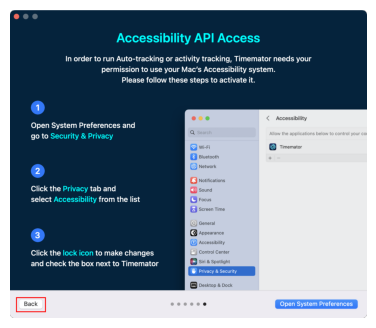

In [29]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Use find_image_path to get the image path for this example
image_path = find_image_path(random_example['Screen id'], all_images)
image, image_base64 = image_to_base64(image_path) 

# Draw bounding box: upper left (546, 62), lower right (676, 100)
draw = ImageDraw.Draw(image)
box_coords = eval(random_example['Answer'])
draw.rectangle(box_coords, outline="red", width=4)

plt.figure(figsize=(8,4))
plt.imshow(image)
plt.axis('off')
plt.show()


In [318]:
# Format the prompt with variables
messages = prompt_template.format_messages(
    screen_width=image.width,
    screen_height=image.height,
    question=random_example['Question'],
    image_base64=f"data:image/jpeg;base64,{image_base64}"
)

llm = llms['reasoning anthropic claude opus 4.1']
response = llm.invoke(messages)
print(response)

content=[{'signature': 'EvcDCkYIBhgCKkCDcq6YJNdZYeSach4lz7Jcp2Esp/v8uakFibzj/gtuh8gAWUlJDXDIFYjhK1Kd7FGFLBaSFJEPAnilpz1V9leyEgx3lmLc1GYamJRlsw0aDNQFm1+1pOnF6G1gJiIwpx+p2JcYNlGRTq89ZGwCPsZuh3qdytkQrltm5tL6jmW4tGPprRjt08BG67oOoy9rKt4Csgzj8n0ttWaYn+UDS2BG6Coh+4TBDWfZ6CbpGroXwC0JDRDAPpxohE6wk4+7mng1hx39FIGW08hJikVmetdgLZXYYOxPIfdmFGhYWRBL80LpkTcYV6Mk2fJOHQGcoUk0T4aJjjgtZzOeD3hT6WyjWSlKStiVLyucmKAPrjVjLDwfZ4yCarI3bwZs+KOAuVj5SPShyFn+rVzRq0xUs0RoP+uJiHKmwViFjPgr4t7RqTXywOKf90XOuMrs8vfQxpGj0TNLecRoNyHncSfTGPdRIJAmSRPTEzla46blpO4OQfedexuaX2AYKOJRXFZaJsXt9WXP5vVpk2AzSz91L9A3Racx/ZMDvkXHhsdgZUBMPe6bC/6vDidvQIlgREZCB+29aud9wEYE7stlB3JThBTDZjF/3JekQ0QLOK0eNoZ8BA/jFpX0HhnVt76SQELqZjSupRkgc8awIklVnSB5Ac0YAQ==', 'thinking': 'The user wants to add a new reminder in what appears to be a Reminders app interface. Looking at the image, I can see a "+" button in the top right corner of the window which is typically used to add new items. The "+" button appears to be located at approximately coordinates (10

In [ ]:
import re

text = response.content[-1]['text']
coords = re.findall(r'\(\s*\d+\s*,\s*\d+\s*\)', text)
coords = [eval(coord) for coord in coords]

ground_truth_coords = eval(random_example['Answer'])

import numpy as np

def iou(boxA, boxB):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes.

    IoU is a metric used to evaluate the overlap between two bounding boxes.
    It is defined as the area of intersection divided by the area of union of the two boxes.
    The value ranges from 0 (no overlap) to 1 (perfect overlap).

    Args:
        boxA: list or tuple of two (x, y) tuples, e.g., [(x1, y1), (x2, y2)]
        boxB: list or tuple of two (x, y) tuples, e.g., [(x1, y1), (x2, y2)]

    Returns:
        float: IoU score between 0 and 1
    """
    # box: (x1, y1), (x2, y2)
    xA = max(boxA[0][0], boxB[0][0])
    yA = max(boxA[0][1], boxB[0][1])
    xB = min(boxA[1][0], boxB[1][0])
    yB = min(boxA[1][1], boxB[1][1])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[1][0] - boxA[0][0]) * (boxA[1][1] - boxA[0][1])
    boxBArea = (boxB[1][0] - boxB[0][0]) * (boxB[1][1] - boxB[0][1])
    unionArea = boxAArea + boxBArea - interArea
    if unionArea == 0:
        return 0.0
    return interArea / unionArea

def centroid_distance(boxA, boxB, image_width, image_height):
    """
    Compute the normalized Euclidean distance between the centroids of two bounding boxes.

    Args:
        boxA: list or tuple of two (x, y) tuples, e.g., [(x1, y1), (x2, y2)]
        boxB: list or tuple of two (x, y) tuples, e.g., [(x1, y1), (x2, y2)]
        image_width: width of the image
        image_height: height of the image

    Returns:
        float: normalized centroid distance (0 = same center, ~1 = farthest possible)
    """
    # Centroid of boxA
    cxA = (boxA[0][0] + boxA[1][0]) / 2
    cyA = (boxA[0][1] + boxA[1][1]) / 2
    # Centroid of boxB
    cxB = (boxB[0][0] + boxB[1][0]) / 2
    cyB = (boxB[0][1] + boxB[1][1]) / 2
    # Euclidean distance
    dist = np.sqrt((cxA - cxB) ** 2 + (cyA - cyB) ** 2)
    # Normalize by image diagonal
    diag = np.sqrt(image_width ** 2 + image_height ** 2)
    if diag == 0:
        return 0.0
    return dist / diag
def calculate_bbox_scores(pred_coords, gt_coords, image_width, image_height):
    """
    Calculate IoU and normalized centroid distance scores between two bounding boxes,
    and return both raw scores and their average.

    Args:
        pred_coords: list or tuple of two (x, y) tuples for predicted box
        gt_coords: list or tuple of two (x, y) tuples for ground truth box
        image_width: width of the image
        image_height: height of the image

    Returns:
        dict: {
            'iou': float,
            'centroid_score': float,
            'average_score': float
        }
    """
    if len(pred_coords) == 2 and len(gt_coords) == 2:
        iou_score = iou(pred_coords, gt_coords)
        centroid_score = 1 - centroid_distance(pred_coords, gt_coords, image_width, image_height)
        average_score = (iou_score + centroid_score) / 2
        return {
            'iou': iou_score,
            'centroid_score': centroid_score,
            'average_score': average_score,
            'ground_truth_coords': gt_coords,
            'pred_coords': pred_coords,
        }
    else:
        return {
            'iou': 0.0,
            'centroid_score': 0.0,
            'average_score': 0.0,
            'ground_truth_coords': gt_coords,
            'pred_coords': pred_coords,
        }

calculate_bbox_scores(coords, ground_truth_coords, image.width, image.height)


{'iou': 0.0,
 'centroid_score': 0.8106668957719817,
 'average_score': 0.40533344788599085,
 'ground_truth_coords': [(1448, 0), (1520, 104)],
 'pred_coords': [(1070, 25), (1093, 48)]}

In [320]:
random_example

{'App bundle': 'com.apple.reminders',
 'App name': 'Reminders',
 'Screen id': 1707082154,
 'Question': 'I want to add a new reminder, where should I click?',
 'Answer': '[(1448, 0), (1520, 104)]',
 'Answer Type': 'coordinates'}

In [321]:
import time

def evaluate_example(example, llm):
    """
    Evaluates a dataset example using the provided LLM.
    If the example is of type 'coordinates', runs calculate_bbox_scores on the AI response.
    Otherwise, runs the rubric grader and returns the raw rubric grade.

    Args:
        example (dict): The dataset example.
        llm: The language model to use for generating responses.

    Returns:
        dict or rubric grade: The result of the evaluation.
    """
    image, _image_base64 = image_to_base64(find_image_path(example.get("Screen id"), all_images))
    # Format the prompt with variables
    messages = prompt_template.format_messages(
        screen_width=image.width,
        screen_height=image.height,
        question=example.get("Question"),
        image_base64=f"data:image/jpeg;base64,{_image_base64}"
    )
    # display(image)
    example_type = example.get("Answer Type", None)

    time_before_ai_response = time.time()
    ai_response = llm.invoke(messages)
    time_after_ai_response = time.time()
    try:
        text = ai_response.content[-1]['text']
    except:
        text = ai_response.content
    
    if example_type == "coordinates":
        # If the LLM returns a string, you may need to parse it here
        
        pred_coords = re.findall(r'\(\s*\d+\s*,\s*\d+\s*\)', text)
        pred_coords = [eval(coord) for coord in pred_coords]
        ground_truth_coords = eval(example['Answer'])

        # You may need to extract image width/height from the example
        image_width = image.width
        image_height = image.height
        if ground_truth_coords and pred_coords:
            answer = calculate_bbox_scores(pred_coords, ground_truth_coords, image_width, image_height)
        else:
            answer = {'average_score': 0, 'score': 0, 'reasoning': 'No coordinates found'}
        answer['time'] = time_after_ai_response - time_before_ai_response
        return answer
    else:        
        rubric_result = score_ai_response(
            question=example['Question'],
            ai_response=text,
            ground_truth=example['Answer']
        )

        rubric_result
        return {'average_score': rubric_result.score / 3, 'score': rubric_result.score, 'reasoning': rubric_result.reasoning, 'time': time_after_ai_response - time_before_ai_response}


In [322]:
results = []

In [487]:
gemini_results = []

In [500]:
from tqdm import tqdm

for idx, example in enumerate(tqdm(dataset['test'].shuffle(seed=42))):
    # Get the indices where the answer type matches
    if idx < len(gemini_results)/len(llms):
        continue
    batch_results = []
    for model_type in llms.keys():
        try:
            eval_answer = evaluate_example(example, llms[model_type])
        except Exception as e:
            eval_answer = {'average_score': None, 'score': None, 'reasoning': 'No response', 'time': None}
        eval_answer['type'] = example['Answer Type']
        eval_answer['model'] = model_type
        eval_answer['question'] = example['Question'] 
        eval_answer['ground_truth_answer'] = example['Answer']
        batch_results.append(eval_answer)
    gemini_results.extend(batch_results)


100%|██████████| 228/228 [15:20<00:00,  4.04s/it]


In [501]:
len(results)

912

In [542]:
results_df = pd.DataFrame(results + gemini_results).dropna(subset=['average_score', 'time'])
results_df.to_csv('reasoning_computer_use_results.csv')
results_df['has_reasoning'] = results_df['model'].apply(lambda x: x.startswith('reasoning') or x.startswith('high reasoning'))
# caveat gemini 2.5 flash lite "no reasoning" is actually "minimal reasoning"
results_df['base_model'] = results_df['model'].apply(lambda x: x.split('reasoning')[-1])
results_df.sample(10)


,average_score,score,reasoning,time,type,model,question,ground_truth_answer,iou,centroid_score,ground_truth_coords,pred_coords,has_reasoning,base_model
1314,1.000000,3.0,The AI response '1' is exactly the same as the...,1.052360,number,high reasoning gemini 2.5 flash lite,How many text input fields are on the screen?,1,NaN,NaN,NaN,NaN,True,gemini 2.5 flash lite
118,0.475394,NaN,NaN,7.205268,coordinates,reasoning anthropic claude opus 4.1,Where do I click to go to YouTube?,"[(162, 172), (326, 228)]",0.000000,0.950787,"[(162, 172), (326, 228)]","[(95, 100), (172, 119)]",True,anthropic claude opus 4.1
710,0.666667,2.0,The AI response states that the average paid a...,6.390369,number,reasoning anthropic claude opus 4.1,"What is the average paid amount for ""Netflix"" ...",440,NaN,NaN,NaN,NaN,True,anthropic claude opus 4.1
798,0.879984,NaN,NaN,7.175303,coordinates,reasoning anthropic claude opus 4.1,Where do I click to connect Gmail?,"[(100, 652), (220, 808)]",0.769193,0.990776,"[(100, 652), (220, 808)]","[(100, 678), (231, 809)]",True,anthropic claude opus 4.1
1126,1.000000,3.0,"The AI response 'No, there is no search bar vi...",1.402797,yes/no,high reasoning gemini 2.5 flash lite,Is there a search bar on the screen?,No,NaN,NaN,NaN,NaN,True,gemini 2.5 flash lite
660,1.000000,3.0,The AI response directly answers the question ...,6.757883,yes/no,reasoning anthropic claude sonnet 4,Is there a searchbar on the screen?,No,NaN,NaN,NaN,NaN,True,anthropic claude sonnet 4
846,1.000000,3.0,The AI response directly states that '8 hours ...,5.186196,number,reasoning anthropic claude opus 4.1,How many hours per day are selected?,8,NaN,NaN,NaN,NaN,True,anthropic claude opus 4.1
1351,1.000000,3.0,The AI response 'This screen is not scrollable...,0.933575,yes/no,minimal reasoning gemini 2.5 flash lite,Is this screen scrollable?,No,NaN,NaN,NaN,NaN,False,gemini 2.5 flash lite
475,1.000000,3.0,The AI response states that there is 1 text in...,4.444709,number,no reasoning anthropic claude opus 4.1,How many text inputs are on the screen?,1,NaN,NaN,NaN,NaN,False,anthropic claude opus 4.1
1077,1.000000,3.0,The AI response states that the 'Timers' tab i...,1.172343,yes/no,minimal reasoning gemini 2.5 flash lite,"Is it ""Alarms"" tab opened on the screen?",No,NaN,NaN,NaN,NaN,False,gemini 2.5 flash lite


In [150]:
# Load the saved results
results_df = pd.read_csv('reasoning_computer_use_results.csv', index_col=0)
results_df['has_reasoning'] = results_df['model'].apply(lambda x: x.startswith('reasoning') or x.startswith('high reasoning'))
# caveat gemini 2.5 flash lite "no reasoning" is actually "minimal reasoning"
results_df['base_model'] = results_df['model'].apply(lambda x: x.split('reasoning')[-1])

In [165]:
mask = (results_df['type'] == 'coordinates')
results_df.loc[mask, 'average_score'] = (
    results_df.loc[mask, ['iou', 'centroid_score']].mean(axis=1)
)
results_df['average_score'] = results_df['average_score'].astype(float)

In [166]:
# Only include numeric columns in the groupby mean to avoid TypeError
numeric_cols = results_df.select_dtypes(include='number').columns
results_df.groupby(['base_model', 'type', 'has_reasoning'])[numeric_cols].mean()

average_score     score  \
base_model                type        has_reasoning                            
anthropic claude opus 4.1 coordinates False               0.453155       NaN   
                                      True                0.464042       NaN   
                          number      False               0.846154  2.538462   
                                      True                0.879365  2.638095   
                          string      False               0.916667  2.750000   
                                      True                0.928571  2.785714   
                          yes/no      False               0.857143  2.571429   
                                      True                0.865591  2.596774   
anthropic claude sonnet 4 coordinates False               0.452369       NaN   
                                      True                0.457289       NaN   
                          number      False               0.866667  2.600000   
                                      True                0.841270  2.523810   
                          string      False               0.964286  2.892857   
                                      True                0.964286  2.892857   
                          yes/no      False               0.888889  2.666667   
                                      True                0.883598  2.650794   
gemini 2.5 flash lite     coordinates False               0.355617  0.000000   
                                      True                0.351820  0.000000   
                          number      False               0.771429  2.314286   
                                      True                0.793651  2.380952   
                          string      False               0.916667  2.750000   
                                      True                0.928571  2.785714   
                          yes/no      False               0.703704  2.111111   
                                      True                0.756614  2.269841   

                                                         time       iou  \
base_model                type        has_reasoning                       
anthropic claude opus 4.1 coordinates False          4.155149  0.088900   
                                      True           8.166761  0.086513   
                          number      False          4.660315       NaN   
                                      True           7.993465       NaN   
                          string      False          3.406948       NaN   
                                      True           5.135968       NaN   
                          yes/no      False          5.052770       NaN   
                                      True           7.513685       NaN   
anthropic claude sonnet 4 coordinates False          2.303398  0.089437   
                                      True           6.188059  0.087391   
                          number      False          3.272556       NaN   
                                      True           6.323008       NaN   
                          string      False          2.323025       NaN   
                                      True           5.310282       NaN   
                          yes/no      False          3.173370       NaN   
                                      True           6.584192       NaN   
gemini 2.5 flash lite     coordinates False          1.429227  0.001883   
                                      True           1.523018  0.005705   
                          number      False          1.189765       NaN   
                                      True           1.309603       NaN   
                          string      False          1.160247       NaN   
                                      True           1.293600       NaN   
                          yes/no      False          1.227382       NaN   
                                      True           1.446852       NaN   

                     

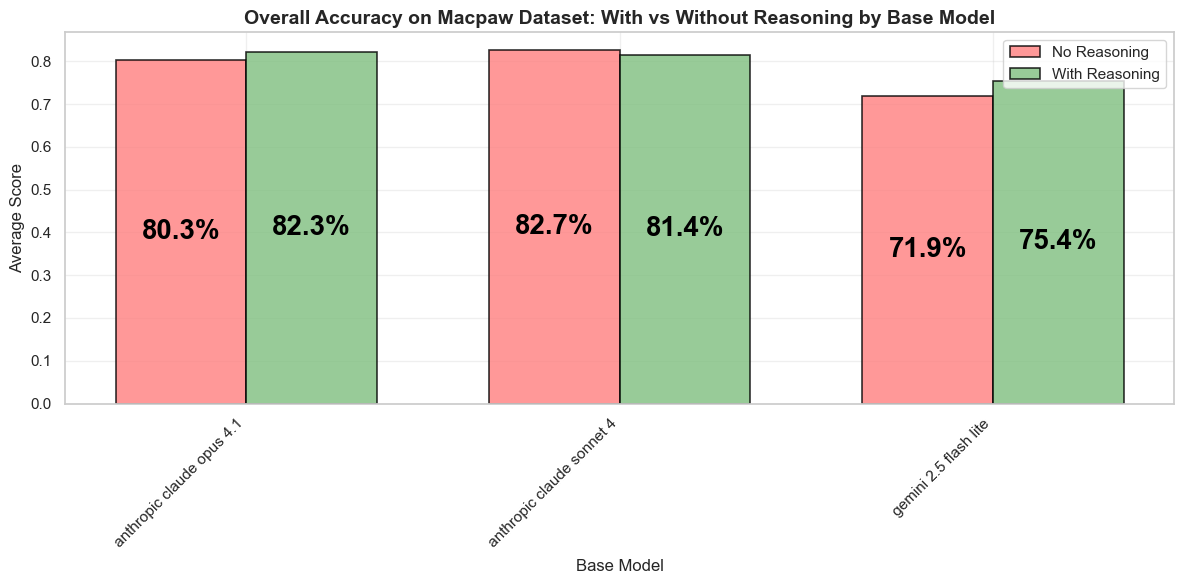

In [167]:
# Create a bar chart comparing overall accuracy with and without reasoning for each base model
grouped_overall = (
    results_df
    .groupby(['base_model', 'has_reasoning'])['average_score']
    .mean()
    .reset_index()
)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique base models
base_models = grouped_overall['base_model'].unique()
x = np.arange(len(base_models))
width = 0.35

# Separate data for reasoning and no reasoning
no_reasoning_data = []
reasoning_data = []

for model in base_models:
    model_data = grouped_overall[grouped_overall['base_model'] == model]
    
    no_reasoning_score = model_data[model_data['has_reasoning'] == False]['average_score']
    reasoning_score = model_data[model_data['has_reasoning'] == True]['average_score']
    
    no_reasoning_data.append(no_reasoning_score.iloc[0] if len(no_reasoning_score) > 0 else 0)
    reasoning_data.append(reasoning_score.iloc[0] if len(reasoning_score) > 0 else 0)

# Create bars with better hatching for colorblind accessibility
bars1 = ax.bar(x - width/2, no_reasoning_data, width, label='No Reasoning', 
               color='#ff7f7f', edgecolor='black', linewidth=1.2,  alpha=0.8)
bars2 = ax.bar(x + width/2, reasoning_data, width, label='With Reasoning', 
               color='#7fbf7f', edgecolor='black', linewidth=1.2, alpha=0.8)

# Customize the plot
ax.set_xlabel('Base Model', fontsize=12)
ax.set_ylabel('Average Score', fontsize=12)
ax.set_title('Overall Accuracy on Macpaw Dataset: With vs Without Reasoning by Base Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(base_models, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels inside bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height / 2,
                f'{height*100:.1f}%',
                ha='center', va='center',
                fontsize=20, fontweight='bold', color='black')

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.show()


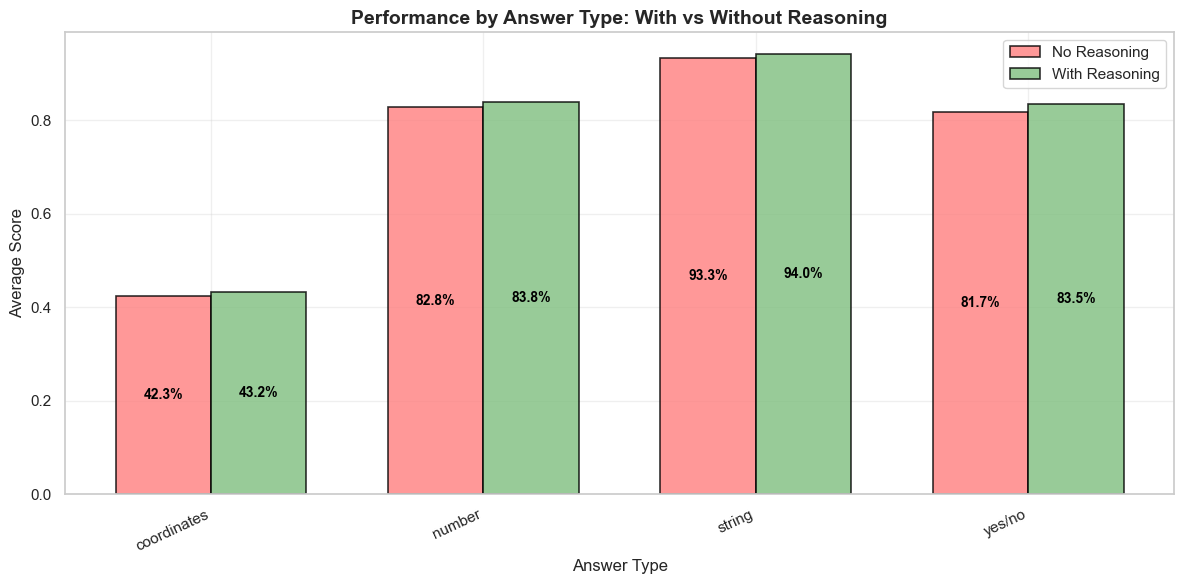


Summary by Answer Type:
has_reasoning  False  True 
type                       
coordinates    0.423  0.432
number         0.828  0.838
string         0.933  0.940
yes/no         0.817  0.835


In [168]:
# Create a comprehensive breakdown by answer type and reasoning status
grouped_by_type = (
    results_df
    .groupby(['type', 'has_reasoning'])['average_score']
    .mean()
    .reset_index()
)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique answer types
answer_types = grouped_by_type['type'].unique()
x = np.arange(len(answer_types))
width = 0.35

# Separate data for reasoning and no reasoning by answer type
no_reasoning_by_type = []
reasoning_by_type = []

for answer_type in answer_types:
    type_data = grouped_by_type[grouped_by_type['type'] == answer_type]
    
    no_reasoning_score = type_data[type_data['has_reasoning'] == False]['average_score']
    reasoning_score = type_data[type_data['has_reasoning'] == True]['average_score']
    
    no_reasoning_by_type.append(no_reasoning_score.iloc[0] if len(no_reasoning_score) > 0 else 0)
    reasoning_by_type.append(reasoning_score.iloc[0] if len(reasoning_score) > 0 else 0)

# Create bars with better hatching for colorblind accessibility
bars1 = ax.bar(x - width/2, no_reasoning_by_type, width, label='No Reasoning', 
               color='#ff7f7f', edgecolor='black', linewidth=1.2, alpha=0.8)
bars2 = ax.bar(x + width/2, reasoning_by_type, width, label='With Reasoning', 
               color='#7fbf7f', edgecolor='black', linewidth=1.2, alpha=0.8)

# Customize the plot
ax.set_xlabel('Answer Type', fontsize=12)
ax.set_ylabel('Average Score', fontsize=12)
ax.set_title('Performance by Answer Type: With vs Without Reasoning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(answer_types, rotation=25, ha='right', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels inside bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only add labels for non-zero bars
            ax.text(bar.get_x() + bar.get_width() / 2, height / 2,
                    f'{height*100:.1f}%',
                    ha='center', va='center',
                    fontsize=10, fontweight='bold', color='black')

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary by Answer Type:")
print(grouped_by_type.pivot(index='type', columns='has_reasoning', values='average_score').round(3))


Filter:   0%|          | 0/228 [00:00<?, ? examples/s]

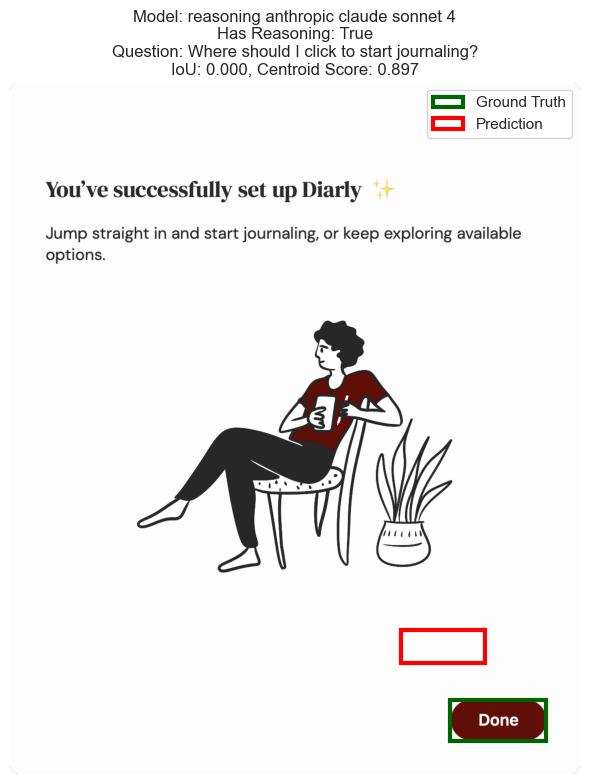

Ground Truth Coordinates: [(866, 1214), (1054, 1294)]
Predicted Coordinates: [(769, 1076), (934, 1142)]
IoU Score: 0.000
Centroid Score: 0.897
Average Score: 0.449


In [169]:
# Get the specific row data
row_data = results_df[(results_df['has_reasoning'] == True) & (results_df['type'] == 'coordinates')].dropna(subset=['average_score']).sort_values(by='average_score', ascending=False).iloc[30]
datapoint = dataset['test'].filter(lambda x: x['Question'] == row_data['question'])
# Load and display the image with coordinate boxes
image_path = find_image_path(datapoint['Screen id'][0], all_images)
img = Image.open(image_path)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(img)

# Extract coordinates - check if they are strings and parse them
ground_truth_coords = row_data['ground_truth_coords']
pred_coords = row_data['pred_coords']

# If coordinates are strings, parse them
if isinstance(ground_truth_coords, str):
    import ast
    ground_truth_coords = ast.literal_eval(ground_truth_coords)
if isinstance(pred_coords, str):
    import ast
    pred_coords = ast.literal_eval(pred_coords)

# Draw dark green box for ground truth coordinates
ground_truth_rect = plt.Rectangle(
    (ground_truth_coords[0][0], ground_truth_coords[0][1]),
    ground_truth_coords[1][0] - ground_truth_coords[0][0],
    ground_truth_coords[1][1] - ground_truth_coords[0][1],
    linewidth=3, edgecolor='darkgreen', facecolor='none', label='Ground Truth'
)
ax.add_patch(ground_truth_rect)

# Draw red box for predicted coordinates
pred_rect = plt.Rectangle(
    (pred_coords[0][0], pred_coords[0][1]),
    pred_coords[1][0] - pred_coords[0][0],
    pred_coords[1][1] - pred_coords[0][1],
    linewidth=3, edgecolor='red', facecolor='none', label='Prediction'
)
ax.add_patch(pred_rect)

# Add legend and title
ax.legend(loc='upper right')
ax.set_title(f"Model: {row_data['model']}\nHas Reasoning: {row_data['has_reasoning']}\nQuestion: {row_data['question']}\nIoU: {row_data['iou']:.3f}, Centroid Score: {row_data['centroid_score']:.3f}")
ax.axis('off')

plt.tight_layout()
plt.show()

# Print details
print(f"Ground Truth Coordinates: {ground_truth_coords}")
print(f"Predicted Coordinates: {pred_coords}")
print(f"IoU Score: {row_data['iou']:.3f}")
print(f"Centroid Score: {row_data['centroid_score']:.3f}")
print(f"Average Score: {row_data['average_score']:.3f}")

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_37909/955019691.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(types, rotation=25, ha='right', fontsize=11)


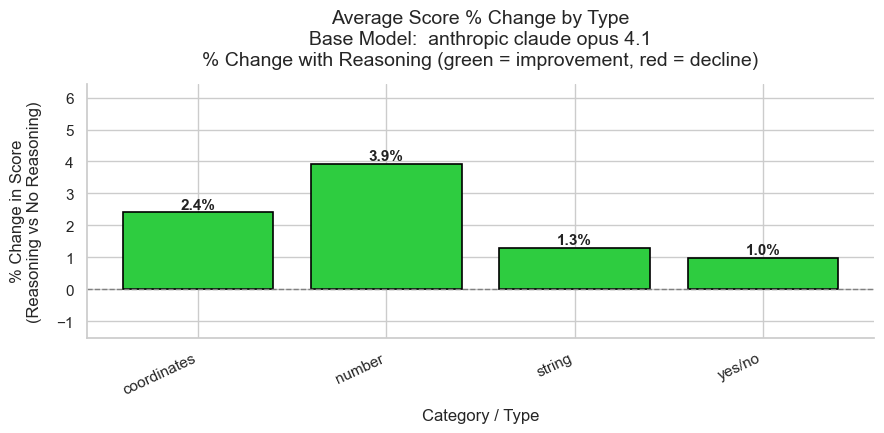

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_37909/955019691.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(types, rotation=25, ha='right', fontsize=11)


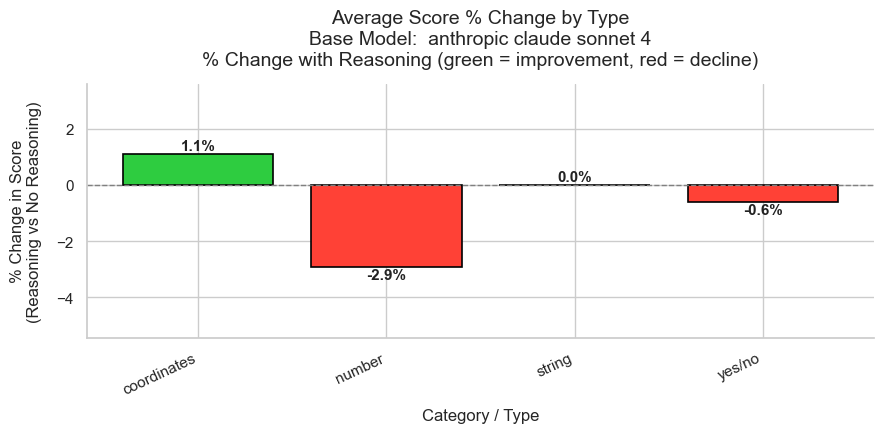

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_37909/955019691.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(types, rotation=25, ha='right', fontsize=11)


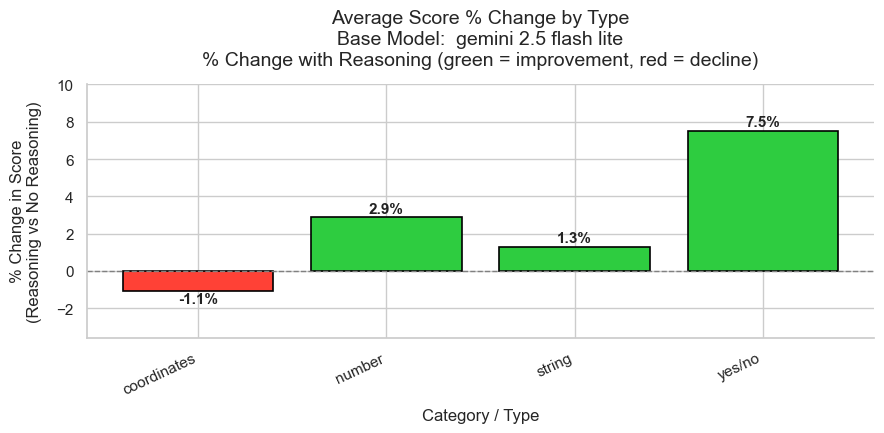

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_37909/955019691.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(types, rotation=25, ha='right', fontsize=11)


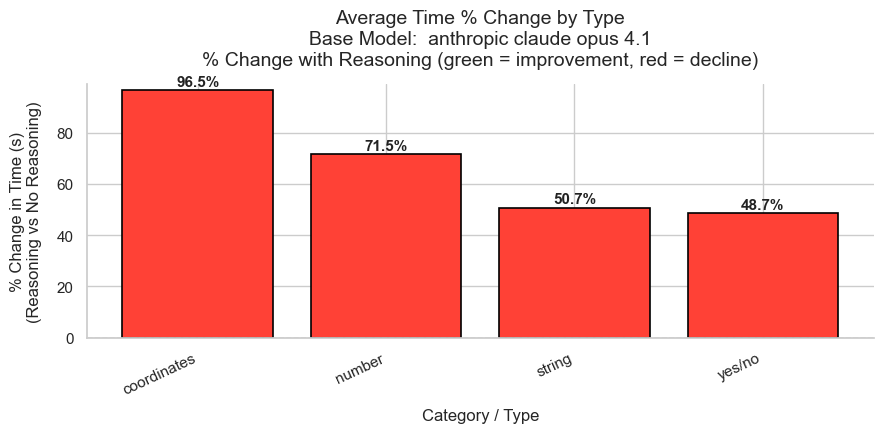

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_37909/955019691.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(types, rotation=25, ha='right', fontsize=11)


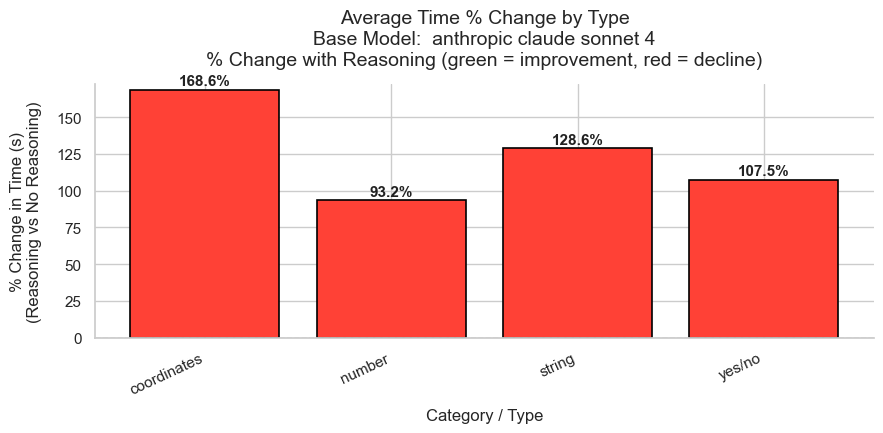

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_37909/955019691.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(types, rotation=25, ha='right', fontsize=11)


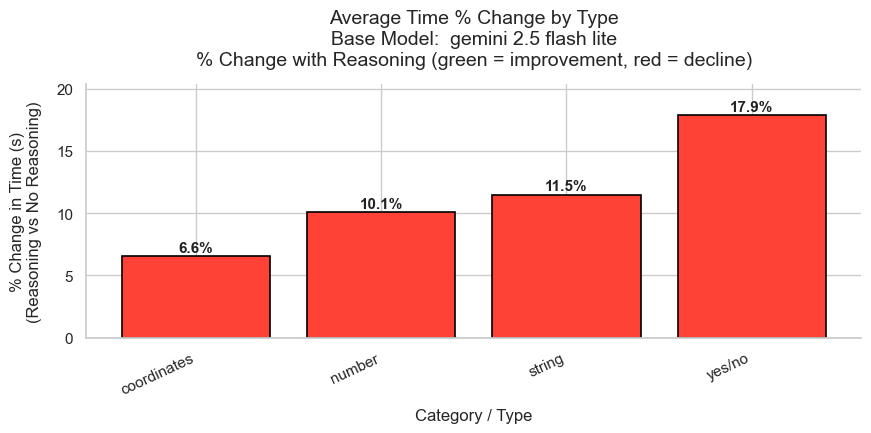

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Group by base_model, has_reasoning, and type for comparison
grouped_df = (
    results_df
    .groupby(['base_model', 'type', 'has_reasoning'])[numeric_cols]
    .mean()
    .reset_index()
)

sns.set(style="whitegrid", font_scale=1.0)

base_models = grouped_df['base_model'].unique()
types = grouped_df['type'].unique()

def plot_percent_change_bar(
    subset, value_col, ylabel, title_prefix, swap_colors=False
):
    """
    Plot a prettified percent change bar chart for a given metric between reasoning and no reasoning.
    """
    # Pivot for plotting: index=type, columns=has_reasoning, values=value_col
    pivot = subset.pivot(index='type', columns='has_reasoning', values=value_col)
    # Ensure both columns (False, True) exist for consistent plotting
    for col in [False, True]:
        if col not in pivot.columns:
            pivot[col] = np.nan
    pivot = pivot.loc[types]  # preserve order

    # Calculate percent change: (Reasoning - No Reasoning) / |No Reasoning| * 100
    no_reasoning = pivot[False]
    reasoning = pivot[True]
    percent_change = ((reasoning - no_reasoning) / np.abs(no_reasoning)) * 100

    # Bar color: green for positive, red for negative (optionally swapped)
    if swap_colors:
        bar_colors = percent_change.apply(lambda x: '#ff4136' if x >= 0 else '#2ecc40')
    else:
        bar_colors = percent_change.apply(lambda x: '#2ecc40' if x >= 0 else '#ff4136')

    fig, ax = plt.subplots(figsize=(9, 4.5))
    bars = ax.bar(types, percent_change, color=bar_colors, edgecolor='black', linewidth=1.2)
    ax.axhline(0, color='gray', linewidth=1, linestyle='--')
    ax.set_ylabel(f"% Change in {ylabel}\n(Reasoning vs No Reasoning)", fontsize=12, labelpad=10)
    ax.set_xlabel("Category / Type", fontsize=12, labelpad=8)
    ax.set_title(
        f"{title_prefix}\n% Change with Reasoning (green = improvement, red = decline)",
        fontsize=14, pad=14
    )
    ax.set_xticklabels(types, rotation=25, ha='right', fontsize=11)

    # Set ylim to avoid annotation cutoffs
    min_val = np.nanmin(percent_change)
    max_val = np.nanmax(percent_change)
    y_range = max_val - min_val
    pad = max(0.05 * y_range, 2.5)  # at least 2.5% padding
    ax.set_ylim(min(min_val - pad, 0), max(max_val + pad, 0))  # always include 0

    # Annotate bars with percent values
    for bar, val in zip(bars, percent_change):
        if not np.isnan(val):
            offset = 0.01 * (max_val - min_val) if max_val != min_val else 1.5
            if val >= 0:
                va = 'bottom'
                y = bar.get_height() + offset
            else:
                va = 'top'
                y = bar.get_height() - offset
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                y,
                f"{val:.1f}%",
                ha='center',
                va=va,
                fontsize=11,
                fontweight='bold',
                color='#222'
            )
    sns.despine()
    plt.tight_layout()
    plt.show()

# Plot percent change in average_score for each base_model
for base_model in base_models:
    subset = grouped_df[grouped_df['base_model'] == base_model]
    plot_percent_change_bar(
        subset,
        value_col='average_score',
        ylabel="Score",
        title_prefix=f"Average Score % Change by Type\nBase Model: {base_model}"
    )

# Plot percent change in time for each base_model
for base_model in base_models:
    subset = grouped_df[grouped_df['base_model'] == base_model]
    plot_percent_change_bar(
        subset,
        value_col='time',
        ylabel="Time (s)",
        title_prefix=f"Average Time % Change by Type\nBase Model: {base_model}",
        swap_colors=True
    )
